In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

seed=42


import os

import torch
import torch.nn as nn
import torch.nn.functional as F
if torch.cuda.is_available():
    print("Yeah we have a GPU!")
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

from gdeep.decision_boundary.decision_boundary_calculator import *
from gdeep.create_nets.sample_nn import SampleCNN_MNIST_SAMPLE,\
    SampleCNN_MNIST_SAMPLE_2


from color_scale import lab_color_scale

In [2]:
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

batch_size = 64

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,))])

# Train set
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

# Filters for labels 3 and 7
trainset_1 = torch.utils.data.Subset(trainset, torch.stack((trainset.targets == 0, trainset.targets == 1), axis=-1).any(-1).nonzero()[:,0])

trainloader = torch.utils.data.DataLoader(trainset_1, batch_size=batch_size,
                                          shuffle=True, num_workers=2,
                                          pin_memory=True)


# Test set
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
# Filters for labels 3 and 7
testset_1 = torch.utils.data.Subset(testset, torch.stack((testset.targets == 0, testset.targets == 1), axis=-1).any(-1).nonzero()[:,0])
testloader = torch.utils.data.DataLoader(testset_1, batch_size=batch_size,
                                         shuffle=False, num_workers=2,
                                         pin_memory=True)

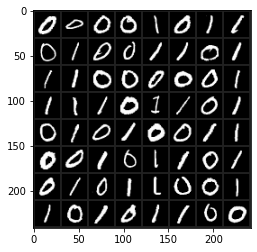

tensor(0) tensor(0) tensor(0) tensor(0)


In [3]:
def imshow(img):
    img = img * 0.3081 + 0.1307     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % labels[j] for j in range(4)))

In [4]:
colormap = lab_color_scale(hue=0.5, rot=250./360, chroma=100., l=40)

def heat_imshow(img, heat):
    img = img * 0.3081 + 0.1307     # unnormalize
    npimg = img.numpy()[:,0,:,:]
    npimg = np.einsum('ikl, im->imkl', npimg ,colormap(heat))
    npimg = torchvision.utils.make_grid(torch.from_numpy(npimg)).numpy()
    return np.transpose(npimg, (1, 2, 0))


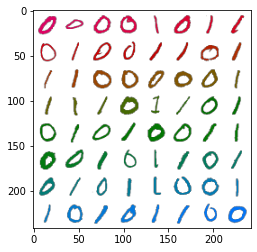

In [5]:
plt.imshow(heat_imshow(images, np.arange(0,1.,1./64)))

In [6]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
heat=heat_imshow(images, np.arange(0,1.,1./64))

In [7]:
digit_detect_nn= SampleCNN_MNIST_SAMPLE().to(dev)

print("Trainable parameters of NN:",\
    sum(p.numel() for p in digit_detect_nn.parameters()), '\n')

print(digit_detect_nn)

Trainable parameters of NN: 61026 

SampleCNN_MNIST_SAMPLE(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)


In [8]:
n_epoch = 6

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(digit_detect_nn.parameters(), lr=0.001, momentum=0.9)


for epoch in range(n_epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(dev)
        labels = labels.to(dev)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = digit_detect_nn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 20 == 19:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 20))
            running_loss = 0.0

print('Finished Training')

[1,    20] loss: 0.670
[1,    40] loss: 0.643
[1,    60] loss: 0.585
[1,    80] loss: 0.459
[1,   100] loss: 0.249
[1,   120] loss: 0.093
[1,   140] loss: 0.044
[1,   160] loss: 0.033
[1,   180] loss: 0.028
[2,    20] loss: 0.021
[2,    40] loss: 0.017
[2,    60] loss: 0.025
[2,    80] loss: 0.018
[2,   100] loss: 0.011
[2,   120] loss: 0.014
[2,   140] loss: 0.016
[2,   160] loss: 0.016
[2,   180] loss: 0.009
[3,    20] loss: 0.010
[3,    40] loss: 0.014
[3,    60] loss: 0.013
[3,    80] loss: 0.011
[3,   100] loss: 0.011
[3,   120] loss: 0.010
[3,   140] loss: 0.011
[3,   160] loss: 0.014
[3,   180] loss: 0.008
[4,    20] loss: 0.010
[4,    40] loss: 0.008
[4,    60] loss: 0.006
[4,    80] loss: 0.013
[4,   100] loss: 0.007
[4,   120] loss: 0.011
[4,   140] loss: 0.006
[4,   160] loss: 0.007
[4,   180] loss: 0.013
[5,    20] loss: 0.005
[5,    40] loss: 0.007
[5,    60] loss: 0.003
[5,    80] loss: 0.010
[5,   100] loss: 0.013
[5,   120] loss: 0.011
[5,   140] loss: 0.003
[5,   160] 

In [9]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(dev)
        labels = labels.to(dev)
        outputs = digit_detect_nn(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %f %%' % (
    100. * correct / total))

Accuracy of the network on the 10000 test images: 99.905437 %


In [10]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(dev)
        labels = labels.to(dev)
        outputs = digit_detect_nn(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(2):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(2):
    print('Accuracy of %5s : %5f %%' % (
        i, 100. * class_correct[i] / class_total[i]))

Accuracy of     0 : 100.000000 %
Accuracy of     1 : 100.000000 %


In [11]:
for param in digit_detect_nn.parameters():
            param.requires_grad = False
model = lambda x: F.softmax(digit_detect_nn(x), dim=-1)

In [16]:
#n_samples = 100

""" g = GradientFlowDecisionBoundaryCalculator(
            model=model,
            initial_points=iter(testloader).next()[0],#torch.distributions.normal.Normal(0.,1.).sample((n_samples, 1, 28, 28)).to(dev),
            optimizer=lambda params: torch.optim.Adam(params)
) """

initial_points = iter(testloader).next()[0].to(dev)
initial_vectors = torch.distributions.normal.Normal(0.,1.).sample(initial_points.shape).to(dev)

initial_vectors = -initial_points

#initial_points = torch.zeros_like(initial_points)
initial_vectors_normalized = torch.einsum('i,i...->i...', 1./torch.sqrt(torch.einsum('i...->i', initial_vectors**2)), initial_vectors)


g = QuasihyperbolicDecisionBoundaryCalculator(
            model=model,
            initial_points=initial_points,#torch.distributions.normal.Normal(0.,1.).sample((n_samples, 1, 28, 28)).to(dev),
            initial_vectors=initial_vectors_normalized
)

steps = 48
stepsize = 5

try:
    os.mkdir("Hyperbolic_Flow_Animation")
except:
    pass

for step in range(steps):
    g.step(stepsize)

    sample_points = g.get_decision_boundary().detach().cpu()
    # Take distance to decision boundary as colormap
    #f_val = torch.abs(model(g.get_decision_boundary())[:, 0].detach()- 0.5).cpu()
    # Take prediction value as colormap
    f_val = torch.clamp(model(g.get_decision_boundary())[:, 0], 0., 1.).detach().cpu()
    

    plt.imshow(np.ascontiguousarray(np.clip(heat_imshow(sample_points, f_val), 0., 1.)))
    plt.title('Number of steps: {:03d}'.format(step * stepsize))
    plt.savefig(os.path.join('Hyperbolic_Flow_Animation','gradient_flow{:03d}.png'.format(step)))
    plt.close()

In [17]:
#! ffmpeg -i Hyperbolic_Flow_Animation/gradient_flow%03d.png Hyperbolic_Flow_MNIST_SAMPLE_new.mp4 -hide_banner -loglevel panic -y
import imageio
import os

folder = 'Hyperbolic_Flow_Animation' 
files = [os.path.join(folder, file) for file in os.listdir(folder)]

images = [imageio.imread(file) for file in files]
imageio.mimwrite('Hyperbolic_Flow_Animation.gif', images, fps=4)